<a href="https://colab.research.google.com/github/GuidoGiacomoMussini/SocialNetworkAnalysis--Algorithm/blob/main/Mnist_SNA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **0 - Initialization**

## 0.1 - Libraries

In [101]:
import os
import shutil
from glob import glob

import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
%matplotlib inline
import random
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import random as rnd
from IPython.display import clear_output 
from tqdm.notebook import tqdm_notebook
from collections import defaultdict, Counter, OrderedDict
import torch
import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as Tf
from keras.datasets import mnist


import networkx as nx

import seaborn as sns

from sklearn import metrics
from sklearn.metrics import classification_report

## 0.2 - Functions

In [102]:
#https://discuss.pytorch.org/t/how-to-show-a-image-in-jupyter-notebook-with-pytorch-easily/1229/4?u=ataraxy
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')

In [103]:
def tensor_mean(tens):
  ex = tens.numpy()
  colmean = ex.mean(axis=1)
  totmean = colmean.mean()
  return totmean

In [104]:
def metrics_definition(net_train, y_train):
  links_list, nodes_list, density_list, centrality_list, clust_list, transitivity_list, label = [], [], [], [], [], [], []

  for i in tqdm_notebook(range(len(net_train))):
    dic =nx.degree_centrality(net_train[i]) 
    dic = list(dic.values())
    centrality_list.append(np.mean(dic))
    links_list.append(net_train[i].number_of_edges())
    nodes_list.append(net_train[i].number_of_nodes())
    density_list.append(nx.density(net_train[i]))
    clust_list.append(nx.average_clustering(net_train[i]))
    transitivity_list.append(nx.transitivity(net_train[i]))

  train_df = pd.DataFrame( columns = ['links', 'nodes', 'density', 'centrality', 'clustering', 'transitivity'])
  train_df['links'] = links_list
  train_df['nodes'] = nodes_list
  train_df['density'] = density_list
  train_df['centrality'] = centrality_list
  train_df['clustering'] = clust_list
  train_df['transitivity'] = transitivity_list
  train_df['label'] = y_train
  return train_df

In [105]:
def alg_mean(train_df, label1, label2):

  avg_links_0, avg_nodes_0, avg_density_0, avg_centrality_0, avg_clust_0, avg_transitivity_0 = 0,0,0,0,0,0
  avg_links_1, avg_nodes_1, avg_density_1, avg_centrality_1, avg_clust_1, avg_transitivity_1 = 0,0,0,0,0,0

  avg_links_0 = train_df.loc[train_df['label'] == label1, 'links'].mean()
  avg_nodes_0 = train_df.loc[train_df['label'] == label1, 'nodes'].mean()
  avg_density_0 = train_df.loc[train_df['label'] == label1, 'density'].mean()
  avg_centrality_0 = train_df.loc[train_df['label'] == label1, 'centrality'].mean()
  avg_clust_0 = train_df.loc[train_df['label'] == label1, 'clustering'].mean()
  avg_transitivity_0 = train_df.loc[train_df['label'] == label1, 'transitivity'].mean()

  avg_links_1 = train_df.loc[train_df['label'] == label2, 'links'].mean()
  avg_nodes_1 = train_df.loc[train_df['label'] == label2, 'nodes'].mean()
  avg_density_1 = train_df.loc[train_df['label'] == label2, 'density'].mean()
  avg_centrality_1 = train_df.loc[train_df['label'] == label2, 'centrality'].mean()
  avg_clust_1 = train_df.loc[train_df['label'] == label2, 'clustering'].mean()
  avg_transitivity_1 = train_df.loc[train_df['label'] == label2, 'transitivity'].mean()

  tr_dist_0 = (avg_links_0, avg_nodes_0, avg_density_0, avg_centrality_0, avg_clust_0, avg_transitivity_0)
  tr_dist_1 = (avg_links_1, avg_nodes_1, avg_density_1, avg_centrality_1, avg_clust_1, avg_transitivity_1)

  return tr_dist_0, tr_dist_1

In [106]:
def array_to_tuple(test_df):
  tpl_list = []

  for i in range(len(test_df)):
    tpl = test_df.loc[i]
    tpl_list.append((tpl[0], tpl[1], tpl[2], tpl[3], tpl[4], tpl[5]))
  return tpl_list

In [107]:
def prediction(tpl_list, label1, label2):
  predicted = []
  for i in range(len(tpl_list)): 
    one = math.dist(tr_dist_1, tpl_list[i])
    zero = math.dist(tr_dist_0, tpl_list[i])
    if one > zero: 
      predicted.append(label1)
    else:
      predicted.append(label2)
  return predicted

# **1 -Dataset transformation**

## 1.1 - prepare the data

import the dataset

In [108]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

retrieve only the 3 and 5 images since they are the most mispredicted 

In [109]:
x_train, y_train, x_test, y_test = [], [], [], []

for i in range(len(X_train)): 
  if Y_train[i] == 5 or  Y_train[i] == 3:
    x_train.append(X_train[i])
    y_train.append(Y_train[i])

for i in range(len(X_test)): 
  if Y_test[i] == 5 or  Y_test[i] == 3:
    x_test.append(X_test[i])
    y_test.append(Y_test[i])

Transform the images into tensor


*   greyscale
*   horizontal flip in te_flp



In [110]:
transform2 = T.Grayscale()
x_tr, x_te, x_te_flp = [], [], []

for i in range(len(x_train)): 
  x_tr.append(transform2(torch.tensor(x_train[i]).unsqueeze_(-1).permute(2,0,1)))

for i in range(len(x_test)): 
  x_te_flp.append(Tf.hflip(torch.tensor(x_test[i]).unsqueeze_(-1).permute(2,0,1)))

for i in range(len(x_test)): 
  x_te.append(torch.tensor(x_test[i]).unsqueeze_(-1).permute(2,0,1))

## 1.2 - define the Adj. Matrix

set to 'black' all the values smaller than the treshold (set to mean(matrix)\10 in this case)

In [111]:
#trasform x_ train in 255-0 form
for tens in tqdm_notebook(range(len(x_tr))): 
  ex = x_tr[tens]
  mean = tensor_mean(ex)
  for h in range(ex.shape[1]): 
    for l in range(ex.shape[2]):

      if h == l: 
        ex[0][h][l] = 0
      elif ex[0][h][l] > mean*10: 
        ex[0][h][l] = 0 

  x_tr[tens] = ex

  0%|          | 0/11552 [00:00<?, ?it/s]

In [112]:
for tens in tqdm_notebook(range(len(x_te))): 
  ex = x_te[tens]
  mean = tensor_mean(ex)
  for h in range(ex.shape[1]): 
    for l in range(ex.shape[2]):

      if h == l: 
        ex[0][h][l] = 0
      elif ex[0][h][l] > mean*10: 
        ex[0][h][l] = 0 

  x_te[tens] = ex

  0%|          | 0/1902 [00:00<?, ?it/s]

In [113]:
for tens in tqdm_notebook(range(len(x_te_flp))): 
  ex = x_te_flp[tens]
  mean = tensor_mean(ex)
  for h in range(ex.shape[1]): 
    for l in range(ex.shape[2]):

      if h == l: 
        ex[0][h][l] = 0
      elif ex[0][h][l] > mean*10: 
        ex[0][h][l] = 0 

  x_te_flp[tens] = ex

  0%|          | 0/1902 [00:00<?, ?it/s]

<ipython-input-114-0595a3ce1c85>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  show(torch.tensor(x_tr[1]))


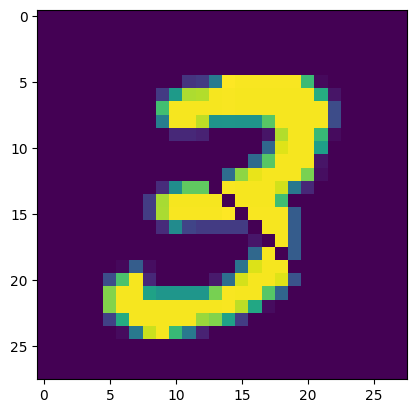

In [114]:
show(torch.tensor(x_tr[1]))

reshape to obtain a Matrix

In [116]:
dim1, dim2 = 28, 28
train, test, test_flp = [], [], []

for i in range(len(x_tr)):
  train.append(x_tr[i].reshape(dim1, dim2).numpy())

for i in range(len(x_te)):
  test.append(x_te[i].reshape(dim1, dim2).numpy())

for i in range(len(x_te_flp)):
  test_flp.append(x_te_flp[i].reshape(dim1, dim2).numpy())

<Axes: >

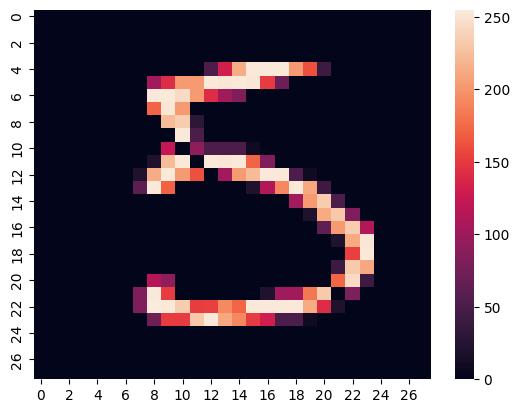

In [117]:
sns.heatmap(train[1])

## 1.3 - Trasform the Adj. Matrices in to a network object

In [118]:
net_train, net_test, net_test_flp = [], [], []

for i in range(len(train)):
  provnet = nx.from_numpy_array(train[i], parallel_edges=False, create_using=None)
  provnet.remove_nodes_from(list(nx.isolates(provnet)))
  net_train.append(provnet)

for i in range(len(test)):
  provnet = nx.from_numpy_array(test[i], parallel_edges=False, create_using=None)
  provnet.remove_nodes_from(list(nx.isolates(provnet)))
  net_test.append(provnet)

for i in range(len(test_flp)):
  provnet = nx.from_numpy_array(test_flp[i], parallel_edges=False, create_using=None)
  provnet.remove_nodes_from(list(nx.isolates(provnet)))
  net_test_flp.append(provnet)

# **2 - Algorithm**

## 2.1 - Training 

derive the metrics

In [120]:
train_df = metrics_definition(net_train, y_train)
test_df = metrics_definition(net_test, y_test)
test_flp_df = metrics_definition(net_test_flp, y_test)

  0%|          | 0/11552 [00:00<?, ?it/s]

  0%|          | 0/1902 [00:00<?, ?it/s]

  0%|          | 0/1902 [00:00<?, ?it/s]

train the algorithm

In [121]:
tr_dist_0, tr_dist_1 = alg_mean(train_df, 3, 5)
te_dist_0, te_dist_1 = alg_mean(test_df, 3, 5)
te_flp_dist_0, te_flp_dist_1 = alg_mean(test_flp_df, 3, 5)

transform the results in tuples

In [122]:
tpl_te_list = array_to_tuple(test_df)
tpl_te_flp_list = array_to_tuple(test_flp_df)

## 2.2 - Prediction

In [123]:
predict_te, predict_te_flp = prediction(tpl_te_list, 3, 5), prediction(tpl_te_flp_list, 3, 5)

Results

In [124]:
ytest = test_df['label']
ytest_flp = test_flp_df['label']

cnf_test = metrics.confusion_matrix(ytest, predict_te)
report_te = metrics.classification_report(ytest, predict_te)


cnf_test_flp = metrics.confusion_matrix(ytest, predict_te_flp)
report_te_flp = metrics.classification_report(ytest, predict_te_flp)


In [ ]:
print("----------------------------TEST--------------------------------\n")
print(report_te, "\n Confusion matrix \n", cnf_test)
print("\n---------------------------------------------------------------- ")
print("---------------------------------------------------------------- \n")
print("----------------------------FLIP TEST---------------------------\n")
print(report_te_flp, "\n Confusion matrix \n", cnf_test_flp)

In [ ]:
cnf_test_flp, print(report_te_flp)